In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error, mean_squared_error

# Read and split the data

In [204]:
data = pd.read_excel("../Data/Pitt_BussType.xlsx", sheetname='Sheet1')

year_data_dict = {}
minYear = data.Years.min()
maxYear = data.Years.max()

for year in range(minYear, maxYear+1):
    year_data_dict[year] = data[data.Years == year]
    
threshold = 0.07

### Train one model per year

In [231]:
model_dict = {}
classifiers = {}

classifiers['Decision Tree'] = Pipeline([('clf', DecisionTreeRegressor())])
classifier_parameters['Decision Tree'] = {}


for year in range(minYear, maxYear):
    year_data = year_data_dict[year]
    x_train = year_data.drop(['Y', 'postal_code', 'Years'], axis =1)
    y_train = year_data.Y
    #clf = GridSearchCV(estimator=classifiers['Decision Tree'], param_grid=classifier_parameters['Decision Tree'])
    clf = DecisionTreeRegressor()
    clf.fit(x_train, y_train)
    model_dict[year] = clf

### Create Similarity Matrix

#### Normalize the Data

In [185]:
df = data
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm.Years = df.Years

#### Split normalized data by year

In [186]:
year_data_dict_norm = {}
minYear = data.Years.min()
maxYear = data.Years.max()

for year in range(minYear, maxYear+1):
    year_data_dict_norm[year] = df_norm[data.Years == year].drop(['postal_code', 'Years', 'Y'], axis = 1)



#### Build the matrix

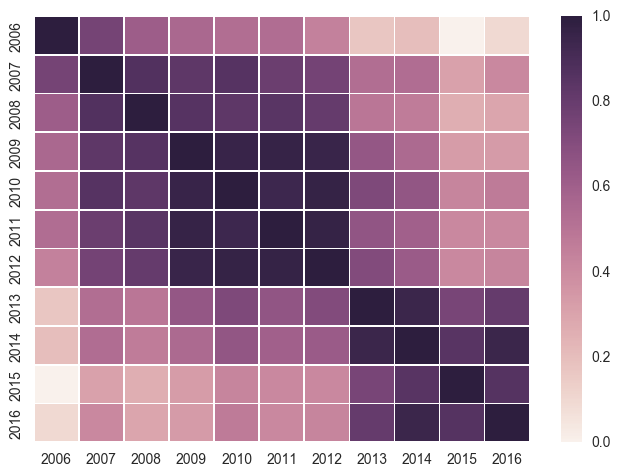

In [187]:
similarity_matrix = pd.DataFrame(columns = range(minYear, maxYear+1))
for year in range(minYear, maxYear+1):
    year_df = []
    for inner_year in range(minYear, maxYear+1):
        x = year_data_dict_norm[year].median().reshape(1,-1)
        y = year_data_dict_norm[inner_year].median().reshape(1,-1)
        dist = cosine_similarity(x, y)[0][0]
        year_df.append(dist) 
    similarity_matrix[year] = year_df
similarity_matrix.index = range(minYear, maxYear+1)

#Normalize the similarities
minSM = similarity_matrix.min().min()
maxSM = 1

similarity_matrix_norm = (similarity_matrix-minSM)/(maxSM-minSM)


sns.heatmap(similarity_matrix_norm, annot=False, linewidths=.5)
plt.show()

### Create New Feature Matrix

In [236]:
weight_training_matrix = pd.DataFrame(columns=['Pred_0', 'Pred_1', 'Pred_2', 'Pred_3', 'Pred_4'])
for outer_year in range(2011, maxYear):
    print(outer_year)
    test_year = outer_year
    test = data[data.Years == test_year]
    x_test = test.drop(['Y', 'postal_code', 'Years'], axis =1)
    y_test = test.Y
    feature_matrix = pd.DataFrame()
    i=0
    sim_weights = [similarity_matrix_norm[outer_year][j] for j in range(test_year-5, test_year)]
    for year in range(test_year-5, test_year):
        clf = model_dict[year]
        similarity_weight = similarity_matrix_norm[year][test_year]
        y_pred = pd.DataFrame(clf.predict(x_test))
        y_pred.columns = ['Y']
        #y_class = np.where(y_pred['Y'] <= threshold, 0, 1)
        y_class = y_pred
        feature_matrix["Pred_" + str(i)] = y_class
        i = i+1
    feature_matrix['Y'] = pd.DataFrame(y_test).reset_index().Y
    #feature_matrix['growth'] = np.where(y_test <= threshold, 0, 1)
    #feature_matrix['Weights'] = np.argmax(sim_weights)
    weight_training_matrix = weight_training_matrix.append(feature_matrix)
weight_training_matrix

2011
2012
2013
2014
2015


,Pred_0,Pred_1,Pred_2,Pred_3,Pred_4,Y
0,0.048780,-0.010363,-0.052632,0.085227,-0.060870,0.027778
1,0.053942,0.018868,-0.009804,0.079365,0.000000,0.000000
2,0.039216,0.000000,0.012500,0.085227,0.020408,0.005525
3,0.039216,-0.009201,-0.010638,0.036036,0.020408,-0.018182
4,0.057971,0.018868,-0.055556,0.000000,0.010309,0.008929
5,0.057971,0.018868,-0.010638,0.000000,0.015388,-0.052239
6,0.039216,-0.009201,-0.026316,0.085227,0.020408,0.013889
7,0.057971,-0.009201,-0.010638,0.085227,0.013366,0.012195
8,0.053942,0.071429,-0.055556,0.079365,0.017094,0.000000
9,0.053942,0.018868,-0.026490,0.000000,0.000000,0.000000


### Train final model

In [237]:
x_train = weight_training_matrix.drop(['Y'], axis=1)
y_train = weight_training_matrix.Y

classifiers['Random Forest'] =  Pipeline([('clf', RandomForestRegressor())])
classifier_parameters['Random Forest'] = {'clf__max_depth':(1, 3, 6, 9, 12, 15), 'clf__n_estimators':(10,20,30)}

classifiers['AdaBoost'] =  Pipeline([('clf', AdaBoostRegressor())])
classifier_parameters['AdaBoost'] = {'clf__loss':('linear', 'square', 'exponential'), 'clf__learning_rate':(0.1, 0.5, 1, 2, 10)}

classifier = 'Random Forest'

clf_final = GridSearchCV(estimator=classifiers[classifier], param_grid=classifier_parameters[classifier])

#clf_final = RandomForestRegressor(n_estimators=20, max_depth=12)

clf_final.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('clf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'clf__max_depth': (1, 3, 6, 9, 12, 15), 'clf__n_estimators': (10, 20, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### Test Model for year 2016

#### Create new feature matrix for 2016

R2: -1.2060051006
MSE: 0.00102767814249


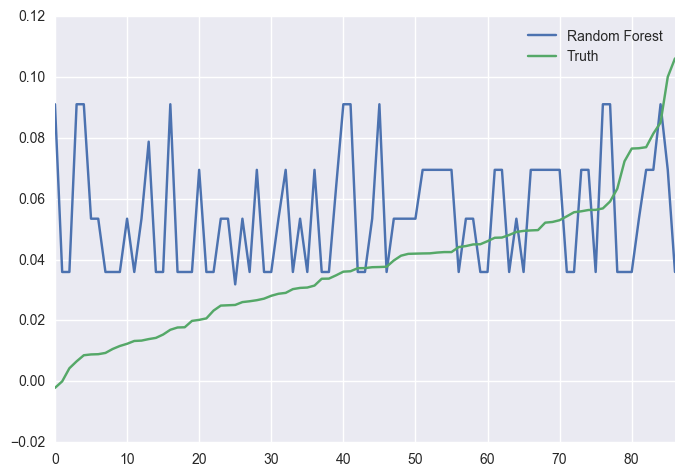

In [238]:
test_year = 2016
test = data[data.Years == test_year]
x_test = test.drop(['Y', 'postal_code', 'Years'], axis =1)
y_test = test.Y
feature_matrix = pd.DataFrame()
i=0
for year in range(test_year-5, test_year):
    clf = model_dict[year]
    similarity_weight = similarity_matrix_norm[year][test_year]
    feature_matrix["Pred_" + str(i)] = clf.predict(x_test)*similarity_weight
    i = i+1
feature_matrix['Y'] = pd.DataFrame(y_test).reset_index().Y

x = feature_matrix.drop('Y', axis=1)
y = feature_matrix.Y

y_pred = clf_final.predict(x)
print("R2: " + str(r2_score(y, y_pred)))
print("MSE: " + str(mean_squared_error(y, y_pred)))

result = pd.DataFrame()
result['Random Forest'] = pd.Series(y_pred)
result['Truth'] = pd.Series(y).reset_index().Y
result.sort_values('Truth').reset_index(drop=True).plot()
plt.show()

### Define Classification Thresholds

In [239]:
result['growth'] = np.where(result['Random Forest'] <= threshold, "NOT HIGH GROWTH", "HIGH GROWTH")
result['growth_True'] = np.where(result['Truth'] <= threshold, "NOT HIGH GROWTH", "HIGH GROWTH")

print(confusion_matrix(result['growth'], result['growth_True']))
print(classification_report(result['growth'], result['growth_True']))

[[ 1 10]
 [ 7 69]]
                 precision    recall  f1-score   support

    HIGH GROWTH       0.12      0.09      0.11        11
NOT HIGH GROWTH       0.87      0.91      0.89        76

    avg / total       0.78      0.80      0.79        87



### Compare to Baseline Method

In [240]:
# Get prediction for previous year
prev_year_pred = pd.DataFrame(year_data_dict[2015][['postal_code', 'Y']])
# Convert to labels
prev_year_pred['growth'] = np.where(prev_year_pred['Y'] <= threshold, "NOT HIGH GROWTH", "HIGH GROWTH")
prev_growth = prev_year_pred.merge(test, on="postal_code")
prev_growth = prev_growth[['growth', 'Y_y']]
prev_growth['growth_new'] = np.where(prev_growth['Y_y'] <= threshold, "NOT HIGH GROWTH", "HIGH GROWTH")
prev_growth=prev_growth.drop('Y_y', axis=1)
prev_growth.columns = ['growth_tminus1', 'growth_tplus1']
y_true = prev_growth.growth_tplus1
y_pred_baseline = prev_growth.growth_tminus1

print(confusion_matrix(y_true, y_pred_baseline))
print(classification_report(y_true, y_pred_baseline))

[[ 4  4]
 [36 41]]
                 precision    recall  f1-score   support

    HIGH GROWTH       0.10      0.50      0.17         8
NOT HIGH GROWTH       0.91      0.53      0.67        77

    avg / total       0.83      0.53      0.62        85

